In [132]:
import pandas as pd
from typing import Callable
import matplotlib.pyplot as plt
import numpy as np
from numpy import array as arr
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from datetime import datetime

# read by default 1st sheet of an excel file
dataframes = pd.read_excel(
    "C:/Users/wisch/Documents/Documents/code/GitProjects/CanopyHydrodynamics/data/validation_raw/StemFlowVolumes.xlsx",
    sheet_name=None,
)
rain_data = pd.read_excel(
    "C:/Users/wisch/Documents/Documents/code/GitProjects/CanopyHydrodynamics/data/validation_raw/2020_Secrest_Hydromet_Data_Volumes.xlsx",
    sheet_name=None,
)
print(dataframes.keys())

dict_keys(['RainEventSummary', 'Hydrograph2022', 'Hydrograph2020', 'RainSummary', 'Mapping', 'TraitExtraction', 'StemFlowVolume', 'DataByArea', 'Volume', 'Depth', 'Yield', 'VolumeByArea', 'YieldByArea', 'DepthByArea'])


In [73]:
# We want to graph correlations between the following extracted
# traits and the volume, depth and yield of flow:
# total_psa, stem_psa, stem_psa_w_overlap, total_surface_area, stem_surface_area
# total_hull_area, stem_hull_area, Total_WAI, stem_WAI,
# DBH, some combination of stem angles

# But first... Data Prep

# Our model hypothesis is that, **assuming initial saturation**, (projected area - overlap) of the stem component will be
# correlated to total stem flow volume. Perhaps there will also be a correlation between surface
# area and stem flow yield or rate

# Cleaning
# Goals:
#   - Reduce the effect of the confounding variables:
#       - Data inaccuracy (for various reasons )
#       - Saturation level varying by tree
#       -
# Methodology:
#   - Identify rain events that did not lead to saturation (varies by tree)
#   - Scrub data for rain events for which no data is available
#   - Normalize the data based on saturation point
#       - *x-axis of mm since Saturation or time since saturation
#   - ?Perhaps adjust for tree pheological traits (species bark roughness?)
#
# Metrics
# - R-squared - The coefficent of determination,


         Date  Rain  Z. serrata  L. styraciflua  A. platanoides  \
7  2020-05-08   0.2        0.00            0.00            0.00   
15 2020-09-09   0.2        0.00            0.00            0.00   
20 2020-04-10   0.3        0.00            0.00            0.00   
9  2020-08-17   0.4        0.00            0.00            0.00   
19 2020-01-10   0.5        0.00            0.00            0.00   
4  2020-02-08   1.1        0.00            0.00            0.00   
18 2020-09-29   1.2        0.00            0.00            0.00   
1  2020-07-28   1.4        0.00            0.00            0.00   
31 2022-10-15   2.2        0.39            0.38            0.00   
2  2020-01-08   2.6        0.00            0.00            0.00   
13 2020-05-09   3.5        0.00            0.00            0.00   
16 2020-09-13   6.6        0.04            0.00            0.00   
32 2022-10-19   7.1        0.01            0.00            0.00   
10 2020-08-26   8.0        0.01            0.00            0.0

In [133]:
# set up - defining the variable
# tree_name = 'A. platanoides'

# Read datasets (excel sheets) into dataframes
rain_intensity = rain_data["Duration"]
volume = dataframes["Volume"]
depth = dataframes["Depth"]
tree_traits = dataframes["Mapping"]

# Set indexes to easily access rows/join data sets
tree_traits.set_index("Species", inplace=True)
depth.set_index("Date", inplace=True)
volume.set_index("Date", inplace=True)
rain_intensity.set_index("Date", inplace=True)




tot_psa = dataframes["Mapping"]["total_psa"].T
stem_psa = dataframes["Mapping"]["stem_psa"].T

tot_surface_area = dataframes["Mapping"]["tot_surface_area"].T
stem_surface_area = dataframes["Mapping"]["stem_surface_area"].T

tot_hull_area = dataframes["Mapping"]["tot_hull_area"].T
stem_hull_area = dataframes["Mapping"]["stem_hull_area"].T

dbh = dataframes["Mapping"]["DBH"].T

Order_zero_angle_avg = dataframes["Mapping"]["Order_zero_angle_avg"].T
Order_two_angle_avg = dataframes["Mapping"]["Order_two_angle_avg"].T


vol_over_tpsa = volume.div(tot_psa)
vol_over_spsa = volume.div(stem_psa)
vol_over_tsa =  volume.div(tot_surface_area)
vol_over_ssa =  volume.div(stem_surface_area)
vol_over_tha =  volume.div(tot_hull_area)
vol_over_sha =  volume.div(stem_hull_area)
vol_over_dbh =  volume.div(dbh)
vol_over_oza =  volume.div(Order_zero_angle_avg)
vol_over_ota =  volume.div(Order_two_angle_avg)
test = volume

date_fix_dict = {
    datetime(2020, 1, 8): datetime(2020, 8, 1),
    datetime(2020, 3, 8): datetime(2020, 8, 3),
    datetime(2020, 4, 8): datetime(2020, 8, 4),
    datetime(2020, 5, 8): datetime(2020, 8, 5),
    datetime(2020, 6, 8): datetime(2020, 9, 6),
    datetime(2020, 7, 9): datetime(2020, 9, 7),
    datetime(2022, 1, 8): datetime(2020, 8, 1),
    datetime(2022, 3, 8): datetime(2020, 8, 3),
    datetime(2022, 4, 8): datetime(2020, 8, 4),
    datetime(2022, 5, 8): datetime(2020, 8, 5),
    datetime(2022, 6, 8): datetime(2020, 9, 6),
    datetime(2022, 7, 9): datetime(2020, 9, 7),
    datetime(2020, 1, 10): datetime(2020, 10, 1),
    datetime(2020, 4, 10): datetime(2020, 10, 4),
    datetime(2022, 2, 8): datetime(2022, 8, 2),
    datetime(2022, 11, 8): datetime(2022, 8, 11),
    datetime(2022, 9, 10): datetime(2022, 9, 10),
    datetime(2022, 2,11): datetime(2022, 11, 2),
    datetime(2022, 1, 10): datetime(2020, 10, 1),
    datetime(2022, 4, 10): datetime(2020, 10, 4),
    datetime(2020, 2, 8): datetime(2022, 8, 2),
    datetime(2020, 11, 8): datetime(2022, 8, 11),
    datetime(2020, 9, 10): datetime(2022, 9, 10),
    datetime(2020, 2,11): datetime(2022, 11, 2),
}

print(date_fix_dict.get("2020-01-08"))
# date_fix_dict = {v:k for k,v in date_fix_dict.items()}
# print(date_fix_dict)
# print(date_fix_dict.get('2020-01-08'))

print(volume.index)
print(volume.index.map(lambda x: date_fix_dict.get(x, x)))
volume.index = volume.index.map(lambda x: date_fix_dict.get(x, x))
print(depth.index)
print(depth.index.map(lambda x: date_fix_dict.get(x, x)))
depth.index = depth.index.map(lambda x: date_fix_dict.get(x, x))


volume_w_intensity = volume.join(rain_data['Duration'], how='left',on='Date')
depth_w_intensity = depth.join(rain_data['Duration'], how='left',on='Date')

# tree_metrics = dataframes['Mapping'].loc[[tree_name]]
rain_sorted_vol = volume_w_intensity.sort_values(by=["Rain"]).query("Rain>0")
# rain_sorted_vol   = volume.sort_values(by=['Rain']).replace(0, np.nan)

# rain_sorted_vol.replace(0, np.nan, inplace=True)

rain_sorted_depth = depth_w_intensity.sort_values(by=["Rain"]).query("Rain>0")
# rain_sorted_depth.replace(0, np.nan, inplace=True)
# rain_sorted_depth = depth.sort_values(by=['Rain']).replace(0, np.nan)




None
DatetimeIndex(['2020-07-27', '2020-07-28', '2020-01-08', '2020-01-08',
               '2020-02-08', '2020-03-08', '2020-04-08', '2020-05-08',
               '2020-08-16', '2020-08-17', '2020-08-26', '2020-08-27',
               '2020-08-28', '2020-05-09', '2020-07-09', '2020-09-09',
               '2020-09-13', '2020-09-28', '2020-09-29', '2020-01-10',
               '2020-04-10', '2022-09-06', '2022-06-17', '2022-07-07',
               '2022-07-14', '2022-07-19', '2022-02-08', '2022-11-08',
               '2022-08-23', '2022-10-09', '2022-09-28', '2022-10-15',
               '2022-10-19', '2022-02-11', '2022-02-11'],
              dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2020-07-27', '2020-07-28', '2020-08-01', '2020-08-01',
               '2022-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-16', '2020-08-17', '2020-08-26', '2020-08-27',
               '2020-08-28', '2020-05-09', '2020-09-07', '2020-09-09',
               '2020-09

In [130]:



tot_psa = dataframes["Mapping"]["total_psa"].T
stem_psa = dataframes["Mapping"]["stem_psa"].T

tot_surface_area = dataframes["Mapping"]["tot_surface_area"].T
stem_surface_area = dataframes["Mapping"]["stem_surface_area"].T

tot_hull_area = dataframes["Mapping"]["tot_hull_area"].T
stem_hull_area = dataframes["Mapping"]["stem_hull_area"].T

dbh = dataframes["Mapping"]["DBH"].T

Order_zero_angle_avg = dataframes["Mapping"]["Order_zero_angle_avg"].T
Order_two_angle_avg = dataframes["Mapping"]["Order_two_angle_avg"].T


vol_over_tpsa = rain_sorted_vol.div(tot_psa)
vol_over_spsa = rain_sorted_vol.div(stem_psa)
vol_over_tsa = rain_sorted_vol.div(tot_surface_area)
vol_over_ssa = rain_sorted_vol.div(stem_surface_area)
vol_over_tha = rain_sorted_vol.div(tot_hull_area)
vol_over_sha = rain_sorted_vol.div(stem_hull_area)

vol_over_dbh = rain_sorted_vol.div(dbh)

vol_over_oza = rain_sorted_vol.div(Order_zero_angle_avg)
vol_over_ota = rain_sorted_vol.div(Order_two_angle_avg)

In [129]:
vol_over_dbh


KeyError: 'Species'

In [146]:
# Adding some segemntattion colums 
print(type(volume_w_intensity['Intensity'].describe()))
print(volume_w_intensity['Intensity'].describe()['50%'])

lambda x,p: x>x.describe()[p]
volume_w_intensity["intensity_color"] = volume_w_intensity['Intensity'].map(lambda x: "r" if x>volume_w_intensity['Intensity'].describe()['50%'] else "b")
volume_w_intensity["intensity_color"] 


# print(depth.index.map(lambda x: date_fix_dict.get(x, x)))

# volume_w_intensity["intensity_color"] = volume_w_intensity[volume_w_intensity['Intensity']>volume_w_intensity['Intensity'].describe()['50%'] ]
# volume_w_intensity["intensity_color"] 

<class 'pandas.core.series.Series'>
1.5714045698924732


Date
2020-07-27    r
2020-07-28    b
2020-08-01    b
2020-08-01    b
2022-08-02    b
2020-08-03    r
2020-08-04    r
2020-08-05    b
2020-08-16    r
2020-08-17    b
2020-08-26    r
2020-08-27    r
2020-08-28    r
2020-05-09    b
2020-09-07    r
2020-09-09    b
2020-09-13    b
2020-09-28    r
2020-09-29    b
2020-10-01    b
2020-10-04    b
2022-09-06    b
2022-06-17    b
2022-07-07    b
2022-07-14    b
2022-07-19    b
2022-08-02    b
2022-08-11    b
2022-08-23    b
2022-10-09    b
2022-09-28    b
2022-10-15    b
2022-10-19    b
2022-11-02    b
2022-11-02    b
Name: intensity_color, dtype: object

In [43]:
# Exclude Dates
#

# rain_sorted_vol = rain_sorted_vol.loc[
#     rain_sorted_vol.index < datetime(2022, 1, 1)
# ]
# bad dates

test = rain_sorted_vol

date_fix_dict = {
    datetime(2020, 1, 8).strftime("YYY-MM-DD"): datetime(2020, 8, 1).strftime(
        "YYY-MM-DD"
    ),
    datetime(2020, 3, 8).strftime("YYY-MM-DD"): datetime(2020, 8, 3).strftime(
        "YYY-MM-DD"
    ),
    datetime(2020, 4, 8).strftime("YYY-MM-DD"): datetime(2020, 8, 4).strftime(
        "YYY-MM-DD"
    ),
    datetime(2020, 5, 8).strftime("YYY-MM-DD"): datetime(2020, 8, 5).strftime(
        "YYY-MM-DD"
    ),
    datetime(2020, 6, 8).strftime("YYY-MM-DD"): datetime(2020, 9, 6).strftime(
        "YYY-MM-DD"
    ),
    datetime(2020, 7, 9).strftime("YYY-MM-DD"): datetime(2020, 9, 7).strftime(
        "YYY-MM-DD"
    ),
    datetime(2020, 1, 10).strftime("YYY-MM-DD"): datetime(2020, 10, 1).strftime(
        "YYY-MM-DD"
    ),
    datetime(2020, 4, 10).strftime("YYY-MM-DD"): datetime(2020, 10, 4).strftime(
        "YYY-MM-DD"
    ),
    datetime(2022, 2, 8).strftime("YYY-MM-DD"): datetime(2022, 8, 2).strftime(
        "YYY-MM-DD"
    ),
    datetime(2022, 11, 8).strftime("YYY-MM-DD"): datetime(2022, 8, 11).strftime(
        "YYY-MM-DD"
    ),
    datetime(2022, 9, 10).strftime("YYY-MM-DD"): datetime(2022, 9, 10).strftime(
        "YYY-MM-DD"
    ),
}

print(rain_sorted_vol.index)
test["adjusted_date"] = date_fix_dict.get(rain_sorted_vol.index, rain_sorted_vol.index)
print(test["adjusted_date"])

DatetimeIndex(['2020-05-08', '2020-09-09', '2020-04-10', '2020-08-17',
               '2020-01-10', '2020-02-08', '2020-09-29', '2020-07-28',
               '2020-01-08', '2020-05-09', '2020-09-13', '2020-08-26',
               '2020-01-08', '2020-08-27', '2020-08-16', '2020-04-08',
               '2020-07-27', '2020-09-28', '2020-03-08', '2020-08-28',
               '2020-07-09'],
              dtype='datetime64[ns]', name='Date', freq=None)


TypeError: unhashable type: 'DatetimeIndex'

In [71]:
#

# vol_bins = [
#     0,
#     3,
#     8,
#     11,
#     13,
#     16,
# ]



,Rain,Z. serrata,L. styraciflua,A. platanoides,B. papyrifera,N. sylvatica,G. dioicus,U. americana,C. japonicum,U. x 'Regal',C. occidentalis,A. rubrum,T. cordata
Date,,,,,,,,,,,,,
2020-05-09,3.5,0.1,0.0,0.0,0.0,0.0,0.0,4.8,0.0,0.0,0.0,0.0,0.00
2020-09-13,6.6,2.7,0.0,0.0,0.3,0.0,0.0,21.8,0.6,0.1,0.5,0.6,0.00
2022-10-19,7.1,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2020-08-26,8.0,0.7,0.0,0.8,0.3,0.0,0.2,5.5,1.0,0.4,1.5,0.9,0.10
2022-02-11,11.2,10.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2022-02-11,11.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2020-01-08,11.3,7.8,1.9,2.0,0.5,0.1,1.3,12.3,2.5,4.7,2.7,5.8,1.40
2022-07-14,11.9,41.0,11.3,40.5,9.6,0.0,1.3,0.0,0.0,12.6,2.0,13.1,0.00
2022-07-07,13.2,5.0,0.0,4.1,2.6,0.0,0.0,0.0,0.0,9.6,1.7,8.7,0.00


KeyboardInterrupt: 

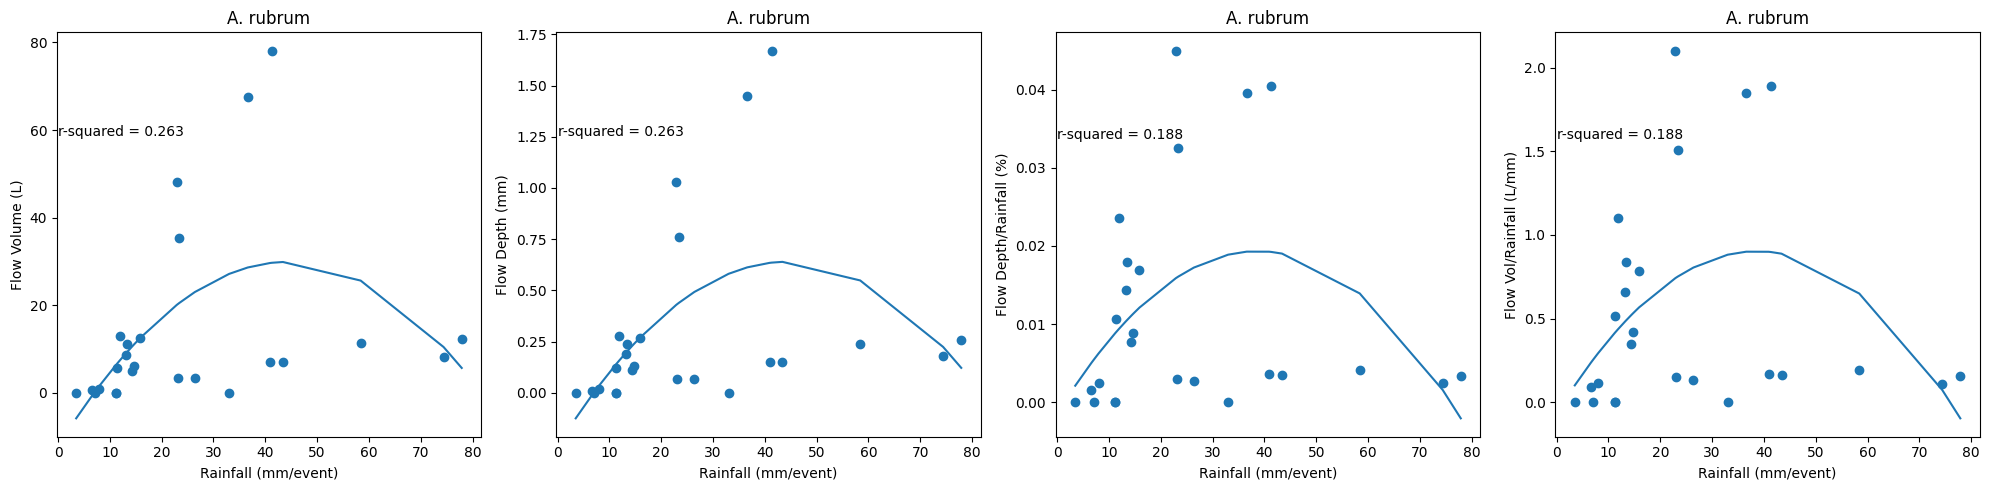

In [95]:
# Identification of saturation point
# How to define:
#   - By volume of rain required before consistent stem flow is seen
#       - By comparison of stem flow vol/yield of each rain event together for each tree individually
#       - Similar to the above but with time on X, stem flow volume on Y for indv rain events
#
# Viz wanted:
#   - Volume/rain depth/stemflow yield by rain amount

# tree_list = set(dataframes['Mapping']['Species'])
# print(tree_list)


import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


if 1 == 1:
    # for tree in tree_list:

    tree_name = "A. rubrum"
    tree_metrics = dataframes["Mapping"].loc[[tree_name]]

    # Creating the plots we are about to populate with data
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    # Populating one plot with data from the validation data set
    title = f"Stemflow Volume (L) by Rainfall Event - {tree_name}"
    ax[0].set_title(tree_name)
    ax[0].set_xlabel("Rainfall (mm/event)")
    ax[0].set_ylabel("Flow Volume (L)")
    x = rain_sorted_vol["Rain"]
    y = rain_sorted_vol[tree_name]
    ax[0].scatter(x, y)

    # Calculating a line of best fit (and its r-squared) to add to the above referenced chart
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    y_predicted = p(x)
    rsq = round(r2_score(y, y_predicted), 3)

    ax[0].annotate(
        f"r-squared = {rsq}",
        (0, np.max(y) * 0.75),
    )
    ax[0].plot(x, y_predicted)

    title = f"Stemflow Depth by Rainfall Event - {tree_name}"
    ax[1].set_title(tree_name)
    ax[1].set_xlabel("Rainfall (mm/event)")
    ax[1].set_ylabel("Flow Depth (mm)")
    x = rain_sorted_depth["Rain"]
    y = rain_sorted_depth[tree_name]
    ax[1].scatter(x, y)
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)

    y_predicted = p(x)
    rsq = round(r2_score(y, y_predicted), 3)

    ax[1].annotate(
        f"r-squared = {rsq}",
        (0, np.max(y) * 0.75),
    )
    ax[1].plot(x, y_predicted)

    title = f"Stemflow Volume Yield by Rainfall Event - {tree_name}"
    ax[2].set_title(tree_name)
    ax[2].set_xlabel("Rainfall (mm/event)")
    ax[2].set_ylabel("Flow Depth/Rainfall (%)")
    x = rain_sorted_depth["Rain"]
    y = rain_sorted_depth[tree_name] / rain_sorted_depth["Rain"]
    ax[2].scatter(x, y)
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)

    y_predicted = p(x)
    rsq = round(r2_score(y, y_predicted), 3)

    ax[2].annotate(
        f"r-squared = {rsq}",
        (0, np.max(y) * 0.75),
    )
    ax[2].plot(x, y_predicted)

    title = f"Stemflow Volume Yield by Rainfall Event - {tree_name}"
    ax[3].set_title(tree_name)
    ax[3].set_xlabel("Rainfall (mm/event)")
    ax[3].set_ylabel("Flow Vol/Rainfall (L/mm)")
    x = rain_sorted_vol["Rain"]
    y = rain_sorted_vol[tree_name] / rain_sorted_vol["Rain"]
    ax[3].scatter(x, y)
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)

    y_predicted = p(x)
    rsq = round(r2_score(y, y_predicted), 3)

    ax[3].annotate(
        f"r-squared = {rsq}",
        (0, np.max(y) * 0.75),
    )
    ax[3].plot(x, y_predicted)

    plt.savefig(
        "C:/Users/wisch/Documents/GitProjects/CanopyHydrodynamics/data/output/validation/A_Rubrum_vol_by_rain.png"
    )

    plt.show()

Processing Z. serrata, Flow Volume (L)


ValueError: x and y must be the same size

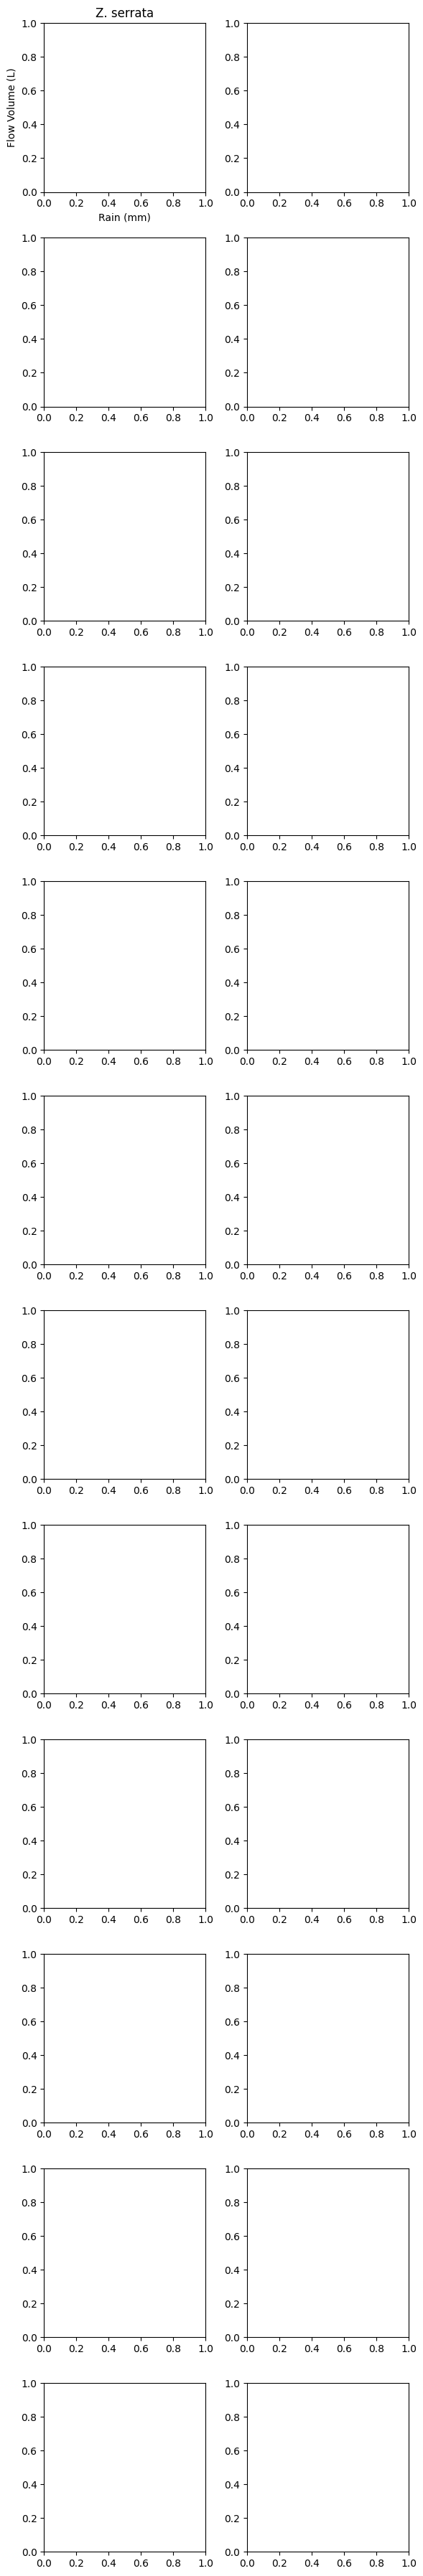

In [25]:
def gaussian(x, a, b, c):
    """
    Used for fitting data using an gaussian curve
    Functions as an input to scipy curve_fit
    """
    y = a * np.exp(-1 * b * x**2) + c
    return y


def exponential(x, a, b, c):
    """
    Used for fitting data using a general exponential curve
    Functions as an input to scipy curve_fit
    """
    return a * np.exp(b * x) + c


def quadratic(x, a, b, c):
    """
    Used for fitting data using a general exponential curve
    Functions as an input to scipy curve_fit
    """
    return a * x * x + b * x + c


def cubic(x, a, b, c):
    """
    Used for fitting data using a general exponential curve
    Functions as an input to scipy curve_fit
    """
    return x * x * x + a * x * x + b * x + c


def logrithmic(x, a, b, c):
    """
    Used for fitting data using a general exponential curve
    Functions as an input to scipy curve_fit
    """

    return a * np.log(b * x) + c


def try_fit_func(fit_func: Callable, x: arr, y: arr, *args):
    func_name = fit_func.__name__
    coeff = []
    try:
        coeff, pcov = curve_fit(fit_func, x, y)  # , p0 = (1,1,2))#, *args)
    except RuntimeError:
        print(f"No {func_name} fit found. {len(coeff)}")

    if len(coeff) == 0:
        y_predicted, rsq = None, None
    else:
        print(f"{func_name} fit found. coeff ={coeff}.")
        y_predicted = fit_func(x, *coeff)
        print(f"x {x}")
        print(f"y {y}")
        print(f"y_predicted {y_predicted}")
        rsq = round(r2_score(y, y_predicted), 3)
        print(f"rsq = {rsq}, args = {args}")
    return y_predicted, rsq, func_name, coeff


def find_fit_func(fit_func, x: arr, y: arr):
    alt_fit_funcs = [logrithmic, quadratic, gaussian, cubic]
    # x_flitered = x[~np.isnan(x)]
    # y_filtered = y[~np.isnan(x)]
    # x_flitered = x[x>0]
    # y_filtered = y[x>0]
    # x_flitered = x[y_filtered>.1]
    # y_filtered = y[y_filtered>.1]
    x_flitered = x
    y_filtered = y

    y_predicted, rsq, fit_func_name, coeff = try_fit_func(
        fit_func, x_flitered, y_filtered
    )

    for alt_func in alt_fit_funcs:
        if len(coeff) != 0 and rsq > 0.2:
            print(
                f"""fff returning:
                  ~np.isnan(x) {~np.isnan(x)} 
                    x {x},
                    x_flitered {x_flitered},
                    y {y},
                    y_filtered {y_filtered}, 
                    y_predicted {y_predicted}"""
            )
            return x_flitered, y_predicted, rsq, fit_func_name, coeff
        else:
            y_predicted, rsq, fit_func_name, coeff = try_fit_func(
                alt_func, x_flitered, y_filtered
            )

    if len(coeff) == 0 or rsq < 0.2:
        fit_func_name = "None"
        y_predicted = y_filtered

    print(f"fff returning: x_flitered {x_flitered}, y_predicted {y_predicted}")
    return x_flitered, y_predicted, rsq, fit_func_name, coeff


def add_plot(
    x, y, fit_func: Callable, plot, title="", xlabel="Rainfall (mm/event)", ylabel=""
):
    # Creating the plots we are about to populate with data

    # Populating one plot with data from the validation data set
    title = f"{title}"
    plot.set_title(title)
    plot.set_xlabel(xlabel)
    plot.set_ylabel(ylabel)
    plot.scatter(x, y)
    # Calculating a line of best fit (and its r-squared) to add to the above referenced chart
    x_flitered, y_predicted, rsq, fit_type, coeff = find_fit_func(
        fit_func, arr(x), arr(y)
    )

    plot.annotate(
        f"r^2 = {rsq}, fit = {fit_type}",
        (0, np.max(y) * 0.9),
    )
    plot.plot(x_flitered, y_predicted)
    return rsq, fit_type, coeff


def cross_plot(rows, cols, common_x, adj_denom=None, fit_func=quadratic):
    num_cols = len(cols) * 2 if adj_denom else len(cols)
    num_rows = len(rows)
    plt.rcParams["figure.autolayout"] = True

    _, ax = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))
    fit_results = []
    for row_number, row_key in enumerate(rows):
        for col_number, col_metric in enumerate(cols):
            xlabel = common_x[0]
            ylabel = col_metric[0]
            title = f"{row_key}"

            print(f"Processing {row_key}, {ylabel}")

            rsq, fit_type, coeff = add_plot(
                x[1],
                col_metric[1][row_key],
                fit_func,
                ax[row_number, col_number],
                title,
                xlabel,
                ylabel,
            )
            fit_results.append((rsq, fit_type, coeff))
            if adj_denom:
                ylabel = f"{col_metric[0]} / {adj_denom[0]}"
                title = f"{row_key}"
                adj_col_num = col_number + len(cols)
                rsq, fit_type, coeff = add_plot(
                    x[1],
                    col_metric[1][row_key] / adj_denom[1],
                    fit_func,
                    ax[row_number, adj_col_num],
                    title,
                    xlabel,
                    ylabel,
                )
                fit_results.append((rsq, fit_type, coeff))


x = ("Rain (mm)", rain_sorted_vol["Rain"])
tree_keyed_data_sets = [
    ("Flow Volume (L)", rain_sorted_depth),
]
# ("Flow Depth (mm)",rain_sorted_depth),]
labels = []
adjustment_denominator = x
# tree list
keys = dataframes["Mapping"].index

# print(rain_sorted_vol)

# print(tree_keyed_data_sets[1][1]['T. cordata'])
# print(tree_keyed_data_sets[1][1]['T. cordata'][len(tree_keyed_data_sets[1][1]['T. cordata'])])
fit_result = cross_plot(
    rows=keys,
    cols=tree_keyed_data_sets,
    common_x=x,
    adj_denom=adjustment_denominator,
    fit_func=exponential,
)

# print(fit_result)
# plt.savefig('C:/Users/wisch/Documents/GitProjects/CanopyHydrodynamics/data/output/validation/munge_test_sort_nan_gr_3_mm_no_r_filter.png')
plt.show()

In [ ]:
# Stemflow Yeild = Total_rainfall_intercepted_by_canopy/stem flow volume
# Total_rainfall_intercepted_by_canopy can be
#  Rain per sq meter mult by...
#       - Tot Hull Area, stem_hull_area, tot_psa, stem_psa, tot/stem surface area


In [118]:
# adjustment_denominator = None

# rain = rain_sorted_vol['Rain']
# x=('Rain (mm)',rain_sorted_vol['Rain'])
# tree_keyed_data_sets = [("Flow Volume (L)",rain_sorted_vol),]
#                         # ("Flow Depth (mm)",rain_sorted_depth),]
# labels = []
# tree_list = dataframes['Mapping'].index

# print(dataframes['Mapping'].loc[['Z. serrata']])

# num = pd.DataFrame({'circle': [4, 4, 4],'triangle': [6, 6, 6],'rectangle': [5, 5, 5]},
#                      index=['a', 'b', 'c'])
# denom = [2,3,5]

# print(num)
# print(num.div(denom))

# print(rain_sorted_vol)
# print(dataframes['Mapping'])


tot_psa = dataframes["Mapping"]["total_psa"].T
stem_psa = dataframes["Mapping"]["stem_psa"].T

tot_surface_area = dataframes["Mapping"]["tot_surface_area"].T
stem_surface_area = dataframes["Mapping"]["stem_surface_area"].T

tot_hull_area = dataframes["Mapping"]["tot_hull_area"].T
stem_hull_area = dataframes["Mapping"]["stem_hull_area"].T

dbh = dataframes["Mapping"]["DBH"].T

Order_zero_angle_avg = dataframes["Mapping"]["Order_zero_angle_avg"].T
Order_two_angle_avg = dataframes["Mapping"]["Order_two_angle_avg"].T

# # print(tot_psa,stem_psa,tot_hull_area,stem_hull_area)

vol_over_tpsa = rain_sorted_vol.div(tot_psa)
vol_over_spsa = rain_sorted_vol.div(stem_psa)
vol_over_tsa = rain_sorted_vol.div(tot_surface_area)
vol_over_ssa = rain_sorted_vol.div(stem_surface_area)
vol_over_tha = rain_sorted_vol.div(tot_hull_area)
vol_over_sha = rain_sorted_vol.div(stem_hull_area)

vol_over_dbh = rain_sorted_vol.div(dbh)

vol_over_oza = rain_sorted_vol.div(Order_zero_angle_avg)
vol_over_ota = rain_sorted_vol.div(Order_two_angle_avg)

# print(tot_psa)
# print(vol_over_tpsa)
# print([col[1].max()[] for col in [('Vol/Tot. PSA' ,vol_over_tpsa),]])


print(vol_over_tpsa["A. platanoides"][vol_over_tpsa["A. platanoides"] > 0])
# (vol_over_spsa
# (vol_over_tha
# (vol_over_sha )

TypeError: cannot perform __truediv__ with this index type: DatetimeArray

fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]
fit_bounds[-100, (100, 100, 100)]


C:\Users\wisch\AppData\Local\Temp\ipykernel_2120\2611310612.py:49: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


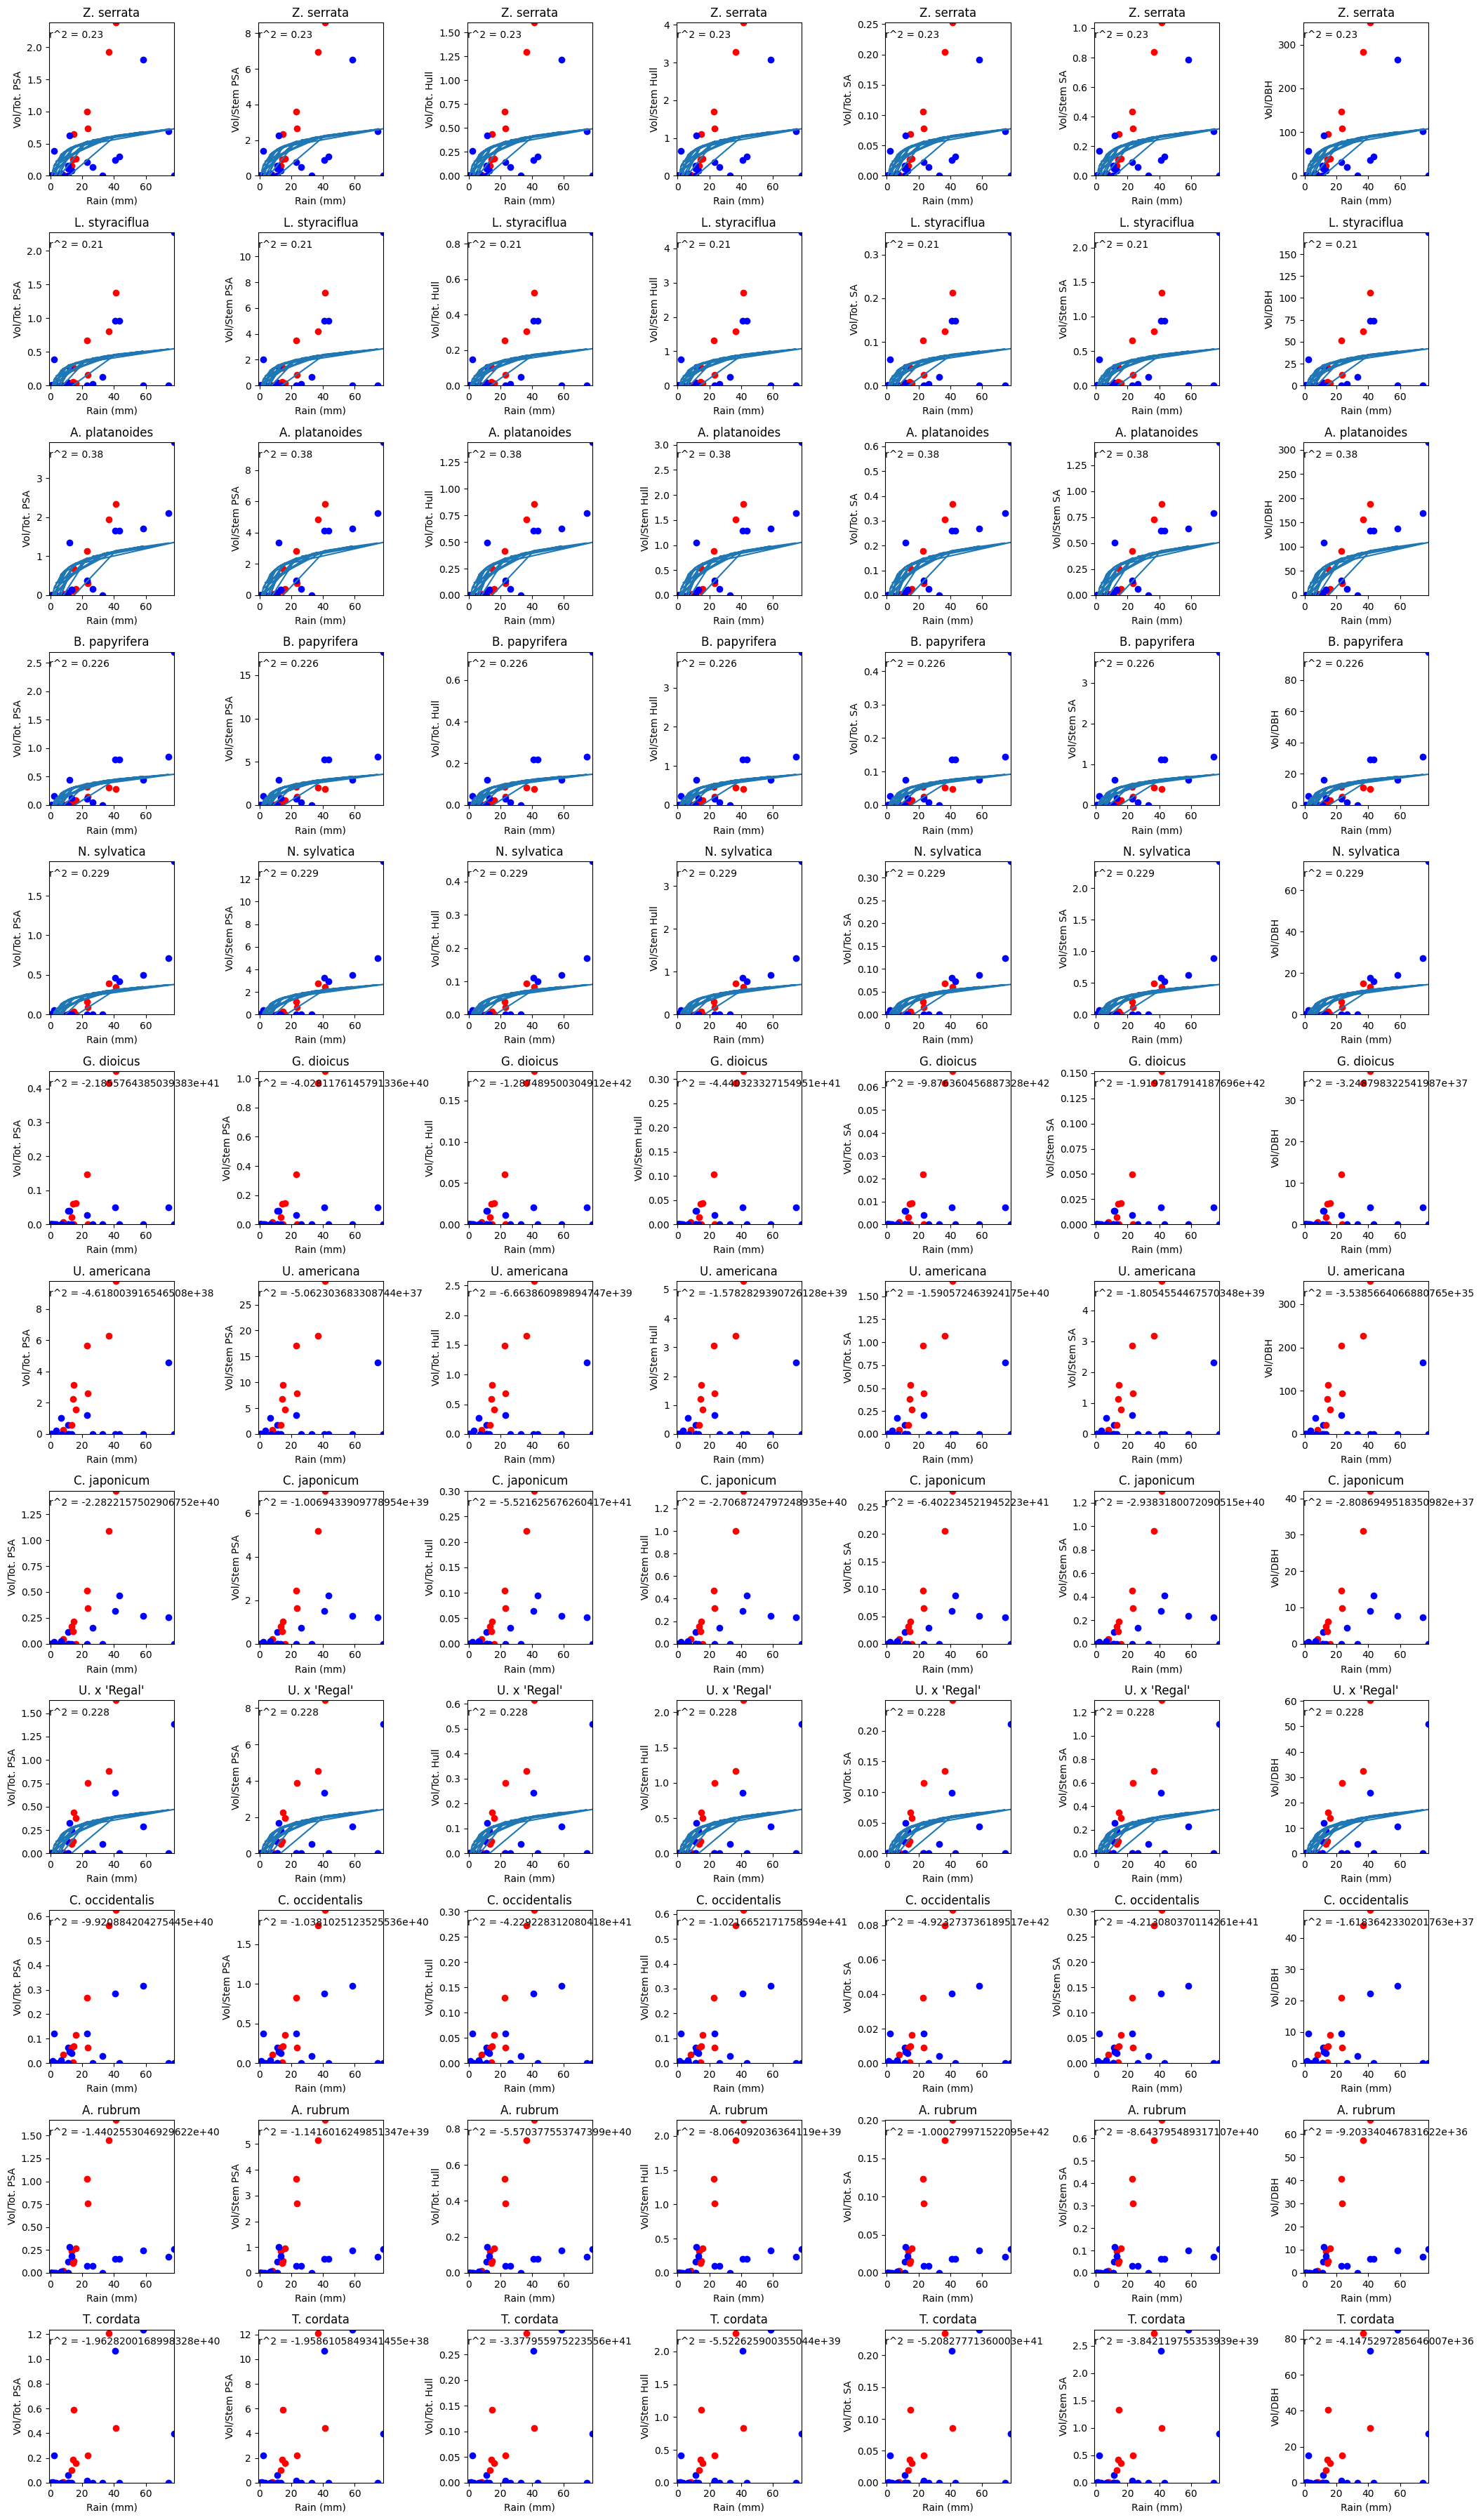

In [147]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
from numpy import array as arr
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


def gaussian(x, a, b, c):
    """
    Used for fitting data using an gaussian curve
    Functions as an input to scipy curve_fit
    """
    y = a * np.exp(-1 * b * x**2) + c
    return y


def exponential(x, a, b, c):
    """
    Used for fitting data using a general exponential curve
    Functions as an input to scipy curve_fit
    """
    return a * np.exp(b * x) + c


def quadratic(x, a, b, c):
    """
    Used for fitting data using a general exponential curve
    Functions as an input to scipy curve_fit
    """
    return a * x * x + b * x + c


def cubic(x, a, b, c):
    """
    Used for fitting data using a general exponential curve
    Functions as an input to scipy curve_fit
    """
    return x * x * x + a * x * x + b * x + c


def natural_log(x, a, b, c):
    """
    Used for fitting data using a general exponential curve
    Functions as an input to scipy curve_fit
    """

    return a * np.log(b * x) + c


def general_log(x, a, b, c):
    """
    Used for fitting data using a general exponential curve
    Functions as an input to scipy curve_fit
    """

    return a * np.emath.logn(b, x) + c


def try_fit_func(fit_func: Callable, x: arr, y: arr, *args):
    func_name = fit_func.__name__
    coeff = []
    if fit_func in ["general_log", "exponential"]:
        bounds = [0.01, (100, 100, 100)]
    if fit_func in ["natural_log"]:
        bounds = [0.01, (100, 4, 100)]
    else:
        bounds = [-100, (100, 100, 100)]
    print(f"fit_bounds{bounds}")
    try:
        coeff, pcov = curve_fit(fit_func, x, y)  # , p0 = (1,1,2))#, *args)
    except RuntimeError:
        print(f"No {func_name} fit found. {len(coeff)}")

    if len(coeff) == 0:
        y_predicted, rsq = None, None
    else:
        # print(f'{func_name} fit found. coeff ={coeff}. x = {x}')
        try:
            y_predicted = fit_func(x, *coeff)
        except RuntimeWarning:
            print(f"Err: x {x}, coeff: {coeff} ")
        # print(f'x {x}')
        # print(f'y {y}')
        # print(f'y_predicted {y_predicted}')
        rsq = round(r2_score(y, y_predicted), 3)
        # print(f'rsq = {rsq}, args = {args}')
    return y_predicted, rsq, func_name, coeff


def find_fit_func(fit_func, x: arr, y: arr):
    alt_fit_funcs = [exponential, natural_log, quadratic, general_log, gaussian, cubic]
    # x_flitered = x[~np.isnan(x)]
    # y_filtered = y[~np.isnan(x)]
    x_flitered = x[x > 0]
    y_filtered = y[x > 0]
    # x_flitered = x[y_filtered>.1]
    # y_filtered = y[y_filtered>.1]
    # x_flitered = x
    # y_filtered = y

    y_predicted, rsq, fit_func_name, coeff = try_fit_func(
        fit_func, x_flitered, y_filtered
    )

    for alt_func in alt_fit_funcs:
        if len(coeff) != 0 and (rsq > 0.2 or rsq < -0.2):
            # print(f'''fff returning:
            #       ~np.isnan(x) {~np.isnan(x)}
            #         x {x},
            #         x_flitered {x_flitered},
            #         y {y},
            #         y_filtered {y_filtered},
            #         y_predicted {y_predicted}''')
            return x_flitered, y_predicted, rsq, fit_func_name, coeff
        else:
            y_predicted, rsq, fit_func_name, coeff = try_fit_func(
                alt_func, x_flitered, y_filtered
            )

    if len(coeff) == 0 or (rsq < 0.2 and rsq > -0.2):
        fit_func_name = "None"
        y_predicted = y_filtered

    # print(f'fff returning: x_flitered {x_flitered}, y_predicted {y_predicted}')
    return x_flitered, y_predicted, rsq, fit_func_name, coeff


def add_plot(
    x,
    y,
    fit_func: Callable,
    plot,
    bounds,
    title="",
    xlabel="Rainfall (mm/event)",
    ylabel="",
    col_map = None
):
    # Creating the plots we are about to populate with data

    # Populating one plot with data from the validation data set
    title = f"{title}"
    plot.set_title(title)
    plot.set_xlabel(xlabel)
    plot.set_ylabel(ylabel)
    plot.set(xlim=bounds[0], ylim=bounds[1])
    
    for idx, (yi, col) in enumerate(zip(y,col_map)):
        plot.scatter(x.iloc[idx], yi, color= col)
    # Calculating a line of best fit (and its r-squared) to add to the above referenced chart
    x_flitered, y_predicted, rsq, fit_type, coeff = find_fit_func(
        fit_func, arr(x), arr(y)
    )

    plot.annotate(
        f"r^2 = {rsq}",
        xy=(bounds[0][0], bounds[1][1] * 0.9),
    )
    plot.plot(x_flitered, y_predicted)
    return rsq, fit_type, coeff


def cross_plot(rows, cols, common_x, fit_func=quadratic, col_map = None):
    num_cols = len(cols)
    num_rows = len(rows)
    plt.rcParams["figure.autolayout"] = True

    _, ax = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))
    fit_results = []
    xmax = x[1].max()
    xmin = x[1].min() - 1
    for row_number, row_key in enumerate(rows):
        # ymin = np.max([col_metric[1][row_key].min() for col_metric in cols])
        # ymax = np.max([col_metric[1][row_key].max() for col_metric in cols])
        # Pdb().set_trace()
        for col_number, col_metric in enumerate(cols):
            ymin = col_metric[1][row_key].min()
            ymax = col_metric[1][row_key].max()
            bounds = ((xmin, xmax), (ymin, ymax))
            xlabel = common_x[0]
            ylabel = col_metric[0]
            title = f"{row_key}"

            # print(f'Processing {row_key}, {ylabel}')
            # print(f'bounds {bounds}')

            rsq, fit_type, coeff = add_plot(
                x[1],
                col_metric[1][row_key],
                fit_func,
                ax[row_number, col_number],
                bounds,
                title,
                xlabel,
                ylabel,
                col_map = col_map
            )
            fit_results.append((rsq, fit_type, coeff))


x = ("Rain (mm)", volume_w_intensity["Rain"])
color_col= volume_w_intensity["intensity_color"]


import matplotlib.cm as cm

# col_map = cm.rainbow(volume_w_intensity["Intensity"]/volume_w_intensity["Intensity"].max())
col_map = volume_w_intensity["intensity_color"]
# tree list
keys = dataframes["Mapping"].index

ys = [
    ("Vol/Tot. PSA", vol_over_tpsa),
    ("Vol/Stem PSA", vol_over_spsa),
    ("Vol/Tot. Hull", vol_over_tha),
    ("Vol/Stem Hull", vol_over_sha),
    (
        "Vol/Tot. SA",
        vol_over_tsa,
    ),
    (
        "Vol/Stem SA",
        vol_over_ssa,
    ),
    (
        "Vol/DBH",
        vol_over_dbh,
    ),
]

# print(volume_w_intensity)

fit_result = cross_plot(rows=keys, cols=ys, common_x=x, fit_func=exponential, col_map =col_map )

# print(fit_result)
# plt.savefig('C:/Users/wisch/Documents/GitProjects/CanopyHydrodynamics/data/output/validation/munge_test_sort_nan_gr_3_mm_no_r_filter.png')
plt.show()